In [1]:
import sys
sys.path.append("/home/wanxinli/EHR-OT/")

import matplotlib.pyplot as plt
from mimic_common import *
import os
import pandas as pd

/home/wanxinli/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
trans_metrics = ['OT', 'TCA', 'MMD']
score_dir = "/home/wanxinli/EHR-OT/outputs/mimic/"
group_name = 'gender'

In [3]:

def ratios_for_metrics(eval_metric, trans_metrics):
    """ 
    Compute ratios for the evaluation metrics (eval_metric)

    :param str eval_metric: evaluation metric, mae or rmse
    :param str trans_metric: transporting metric, OT, TCA or MMD
    """

    metric_improve_ratios = []
    for trans_metric in trans_metrics:
        score_path = os.path.join(score_dir, f"exp4_{group_name}_{trans_metric}.csv")
        score_df = pd.read_csv(score_path, header=0, index_col=0)

        # compute improvements in terms of ratio
        metric_improve_ratios.append(compute_metric_ratio(score_df, eval_metric))

    return metric_improve_ratios


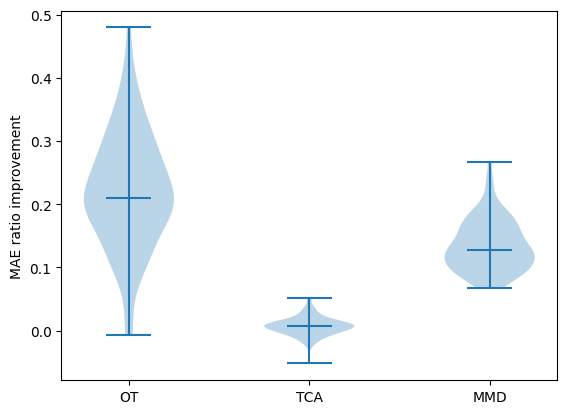

In [4]:
mae_improve_ratios = ratios_for_metrics('mae', trans_metrics)

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: mae_improve_ratios[0],
    trans_metrics[1]: mae_improve_ratios[1], 
    trans_metrics[2]: mae_improve_ratios[2]
})

# Plot the dataframe
plt.violinplot(data, showmedians=True)
plt.xticks([1, 2, 3], labels=['OT', 'TCA', 'MMD'])
plt.ylabel("MAE ratio improvement")
plt.show()



          OT       TCA       MMD
0   0.172130  0.004270  0.083127
1   0.145794 -0.001927  0.149265
2   0.143814  0.010139  0.176918
3   0.148256 -0.003603  0.123135
4   0.061197  0.001298  0.153628
..       ...       ...       ...
95  0.134487  0.001144  0.126316
96  0.290161 -0.008935  0.148538
97  0.143886  0.009086  0.080418
98  0.306928  0.012036  0.116779
99  0.113384 -0.005678  0.038414

[100 rows x 3 columns]


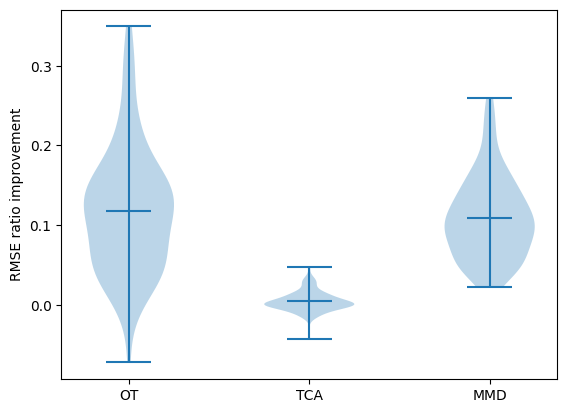

In [5]:
rmse_improve_ratios = ratios_for_metrics('rmse', trans_metrics)

# Pandas dataframe
data = pd.DataFrame({
    trans_metrics[0]: rmse_improve_ratios[0],
    trans_metrics[1]: rmse_improve_ratios[1], 
    trans_metrics[2]: rmse_improve_ratios[2]
})
print(data)

# Plot the dataframe
plt.violinplot(data, showmeans=True)
plt.xticks([1, 2, 3], labels=['OT', 'TCA', 'MMD'])
plt.ylabel("RMSE ratio improvement")
plt.show()

